In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

In [2]:
micro = pd.read_csv('microwave.tsv', sep='\t')
hair = pd.read_csv('hair_dryer.tsv', sep='\t')
pacf = pd.read_csv('hair_dryer.tsv', sep='\t')

In [3]:
hair.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,34678741,R9T1FE2ZX2X04,B003V264WW,732252283,remington ac2015 t|studio salon collection pea...,Beauty,5,0,0,N,Y,Works great,Works great!,8/31/2015
1,US,11599505,RE36JAD5V53PO,B0009XH6V4,670161917,andis micro turbo hair dryer,Beauty,4,0,0,N,Y,I love travel blow dryers because they are eas...,"This dries my hair faster that bigger, more po...",8/31/2015
2,US,2282190,RIDHM8B7SCCV3,B0007NZPY6,16483457,conair pro hair dryer,Beauty,5,0,1,N,Y,Five Stars,Love this dryer!,8/31/2015
3,US,43669858,R14QGWPCHU9LSE,B00BB8ZIW0,253917972,remington silk ceramic professional hair dryer,Beauty,5,0,0,N,Y,Five Stars,styling hair in style,8/31/2015
4,US,107098,R35BHQJHXXJD59,B003V264WW,732252283,remington ac2015 t|studio salon collection pea...,Beauty,4,0,0,N,N,I think's great. The cord length is perfect,I just got this last week. I think's great. Th...,8/31/2015


### 可视化星级与字符串长度的关系

In [4]:
df = pd.DataFrame(columns=['x', 'y'])
for i in range(5):
    a = micro[micro['star_rating']==(i+1)]
    length = a['review_body'].apply(len)
    k = pd.DataFrame({'x':i+1,
                      'y':length})
    df = pd.concat([df, k], axis=0)

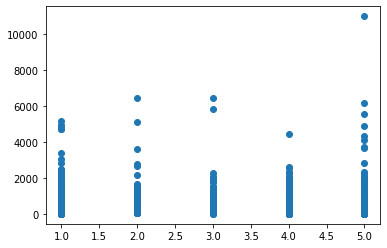

In [5]:
#可视化
plt.scatter(df['x'], df['y'],  )

### tfidf线性回归

In [6]:
# new_hair_cut = []#存储每个顾客评价的分词
# for i in range(11471):
#     k = hair_cut[hair_cut['line']==i]#line相同的df
#     k = k['word'].tolist()
#     if len(k) != 0:
#         new_hair_cut.append(k)
# print(len(new_hair_cut))
# print(len(set(hair_cut['line'])))

In [7]:
# index = set(hair_cut['line'])#索引相同index的score
# index = [i-1 for i in index]
# score = hair.loc[index, ['star_rating']]
# score = score['star_rating'].tolist()#为了便于读取数据
# hair_cut = pd.DataFrame({'score':score,
#                          'word':new_hair_cut})

In [8]:
# hair_train = hair.iloc[:10000, :]
# hair_test = hair.iloc[10000:, :]
# hair_score_train = hair.loc[:10000, 'star_rating']
# hair_score_test = hair.loc[10000:, 'star_rating']
# hair_score_train = np.array(hair_score_train).reshape(-1, 1)
# hair_score_test = np.array(hair_score_test).reshape(-1, 1)

#### 训练集：测试集=10000:1470

In [9]:
hair_cut = pd.read_csv('hair_dryer_line_seperate_words.csv')
ncr = pd.read_csv('nrc.csv')

In [10]:
corpus = hair['review_body'].tolist()
#将文本中的词语转换为词频矩阵  
vectorizer = CountVectorizer()  
#计算个词语出现的次数  
X = vectorizer.fit_transform(corpus)  
#获取词袋中所有文本关键词  
word = vectorizer.get_feature_names()  
transformer = TfidfTransformer()  
print(transformer)  
#将词频矩阵X统计成TF-IDF值  
tfidf = transformer.fit_transform(X)  

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)


In [11]:
#建立所有词汇的tf-idf矩阵
tfidf = tfidf.toarray()
tfidf = pd.DataFrame(tfidf, columns=word)
hair_score = hair['star_rating']
ths = pd.concat([hair_score, tfidf], axis=1)

In [12]:
#删除全部为0的列
# n = 0
# a = {0}
# valid_word = []
# for i in word:
#     if set(tfidf[:, n])!=a:
#         valid_word.append(n)
#     n = n + 1

In [13]:
#建立只有情感词汇的tf-idf矩阵，删除横轴为空的向量；
ncr = [i for i in word if i in ncr]
ncr.append('star_rating')
ths = ths.loc[:, ncr]
dropall = ths.loc[~(ths==0).all(axis=1), :]

In [14]:
#清洗发现每个纵轴都有非零数据
ncr.remove('star_rating')
tfidf_train = np.array(ths.loc[0:8000, ncr])
tfidf_test = np.array(ths.loc[8000:, ncr])
tfidf_score_train = np.array(ths.loc[0:8000, 'star_rating'])
tfidf_score_test = np.array(ths.loc[8000:, 'star_rating'])
# n = 0
# a = {0}
# valid_word = []
# old_world = droprow.columns
# for i in old_world:
#     if set(droprow.iloc[:, n])!=a:
#         valid_word.append(i)
#     n = n + 1
# dropall = droprow.loc[:, valid_word]#

In [26]:
a1 = time.perf_counter()
regress=LinearRegression()
regress.fit(tfidf_train, tfidf_score_train)
a2 = time.perf_counter()
a2-a1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
tfidf_score_predict = regress.predict(tfidf_test)

array([4.19076033, 4.19076033, 4.19076033, ..., 4.19076033, 4.19076033,
       4.19076033])

In [69]:
mse = np.power((tfidf_score_predict-tfidf_score_test), 2)

In [70]:
num = 0
for i in range(len(tfidf_score_predict)):
    a = round(tfidf_score_predict[i])
    if (a-tfidf_score_test[i])<=1:#预测相差2星以内均可接受
        num = num + 1
num

2822

#### 寻找大系数

In [71]:
regress.coef_.argsort()

array([0])

In [72]:
regress.coef_[878]

IndexError: index 878 is out of bounds for axis 0 with size 1

In [73]:
word[78+275]

'6years'

In [74]:
a = abs(hair_score_predict-hair_score_test)
b = np.where(a<0.5, 1, 0)

NameError: name 'hair_score_predict' is not defined

In [75]:
hair_test

NameError: name 'hair_test' is not defined

In [76]:
a = np.max(tfidf, axis=1)
b = a.argsort()

只保留有情感特征词的tf-idf值构建向量，对于评论中无相应词汇的评论假定对评分无参考，或构建另一套中肯评价体系进行打分；参考文献
情绪类评价有较少的赞同反馈，中肯类评价能收到更多反馈

In [77]:
print(tfidf.shape)

(11470, 12378)


In [78]:
print(ths.shape)

(11470, 2)


In [79]:
print(dropall.shape)

(11470, 2)


In [80]:
s = []
for i in range(len(tfidf_score_predict)):
    a = round(tfidf_score_predict[i])
    s.append(a)
pd.DataFrame({'predict':s,
             'real':tfidf_score_test})

,predict,real
0,4.0,5
1,4.0,5
2,4.0,4
3,4.0,3
4,4.0,1
...,...,...
3465,4.0,5
3466,4.0,1
3467,4.0,5
3468,4.0,5
